## Introduction

In this project, I focused on developing a robust time series forecasting model for sales prediction, leveraging the knowledge gained from the Kaggle Learn Time Series Forecasting module. The aim was to create an accurate and reliable predictive model by systematically exploring the dataset, refining it through preprocessing, and employing advanced modeling techniques.

Below are the key aspects of my approach:

1. Data Analysis and Impact Assessment: Thorough examination of the provided dataframes to evaluate their structure, relevance, and influence on the target variable, specifically focusing on sales prediction.

2. Data Preprocessing: Implementation of advanced data cleaning techniques, including the removal of irrelevant data points and the resolution of inconsistencies to ensure data integrity.

3. Feature Engineering: Strategic development of new features and transformation of existing variables to enhance the predictive power of the models.

4. Baseline Model Development: Construction of an initial model to capture underlying patterns, particularly focusing on trend and seasonality components in sales data.

5. Hybrid Modeling Techniques: Integration of various modeling approaches to combine the strengths of different methods, aiming to improve the accuracy of sales forecasts.

In [ ]:
!pip install learntools

In [ ]:
!git clone https://github.com/Kaggle/learntools.git
!mv learntools learntools_dir
!mv learntools_dir/learntools learntools

fatal: destination path 'learntools' already exists and is not an empty directory.


In [ ]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

## Understanding the Training data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Placement projects/store-sales-time-series-forecasting/train.csv',
                parse_dates = ['date'],
                infer_datetime_format = True,)
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


* **store_nbr** identifies the store at which the products are sold.
* **family** identifies the type of product sold.
* **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

In [ ]:
# Check for missing data
missing_data = df.isnull().sum()
print("Missing data in each column:\n", missing_data)

# Handling missing data for numerical columns by filling with mean
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

# Handling missing data for categorical columns by filling with mode
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# Verify if all missing data has been handled
missing_data_after = df.isnull().sum()
print("Missing data after handling:\n", missing_data_after)


Missing data in each column:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
Missing data after handling:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


**Whoa! There are 3000888 entries in this training dataframe. Quite Huge! No worries let us break this to bits to understand the most of it.**

In [ ]:
df.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [ ]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
print("There are", len(df.store_nbr.unique()), "stores and", len(df.family.unique()), "family of stores in the given training data frame.")

There are 54 stores and 33 family of stores in the given training data frame.


## Approach
* Identify the trend component and predict for trend component (y_pred_trend)
* On top of the detrended target, fit a model and predict the seasonality component (y_pred_seasonality).
* Predict for the cycle on the residual target value
* Finally add all three component to achieve the final target value.

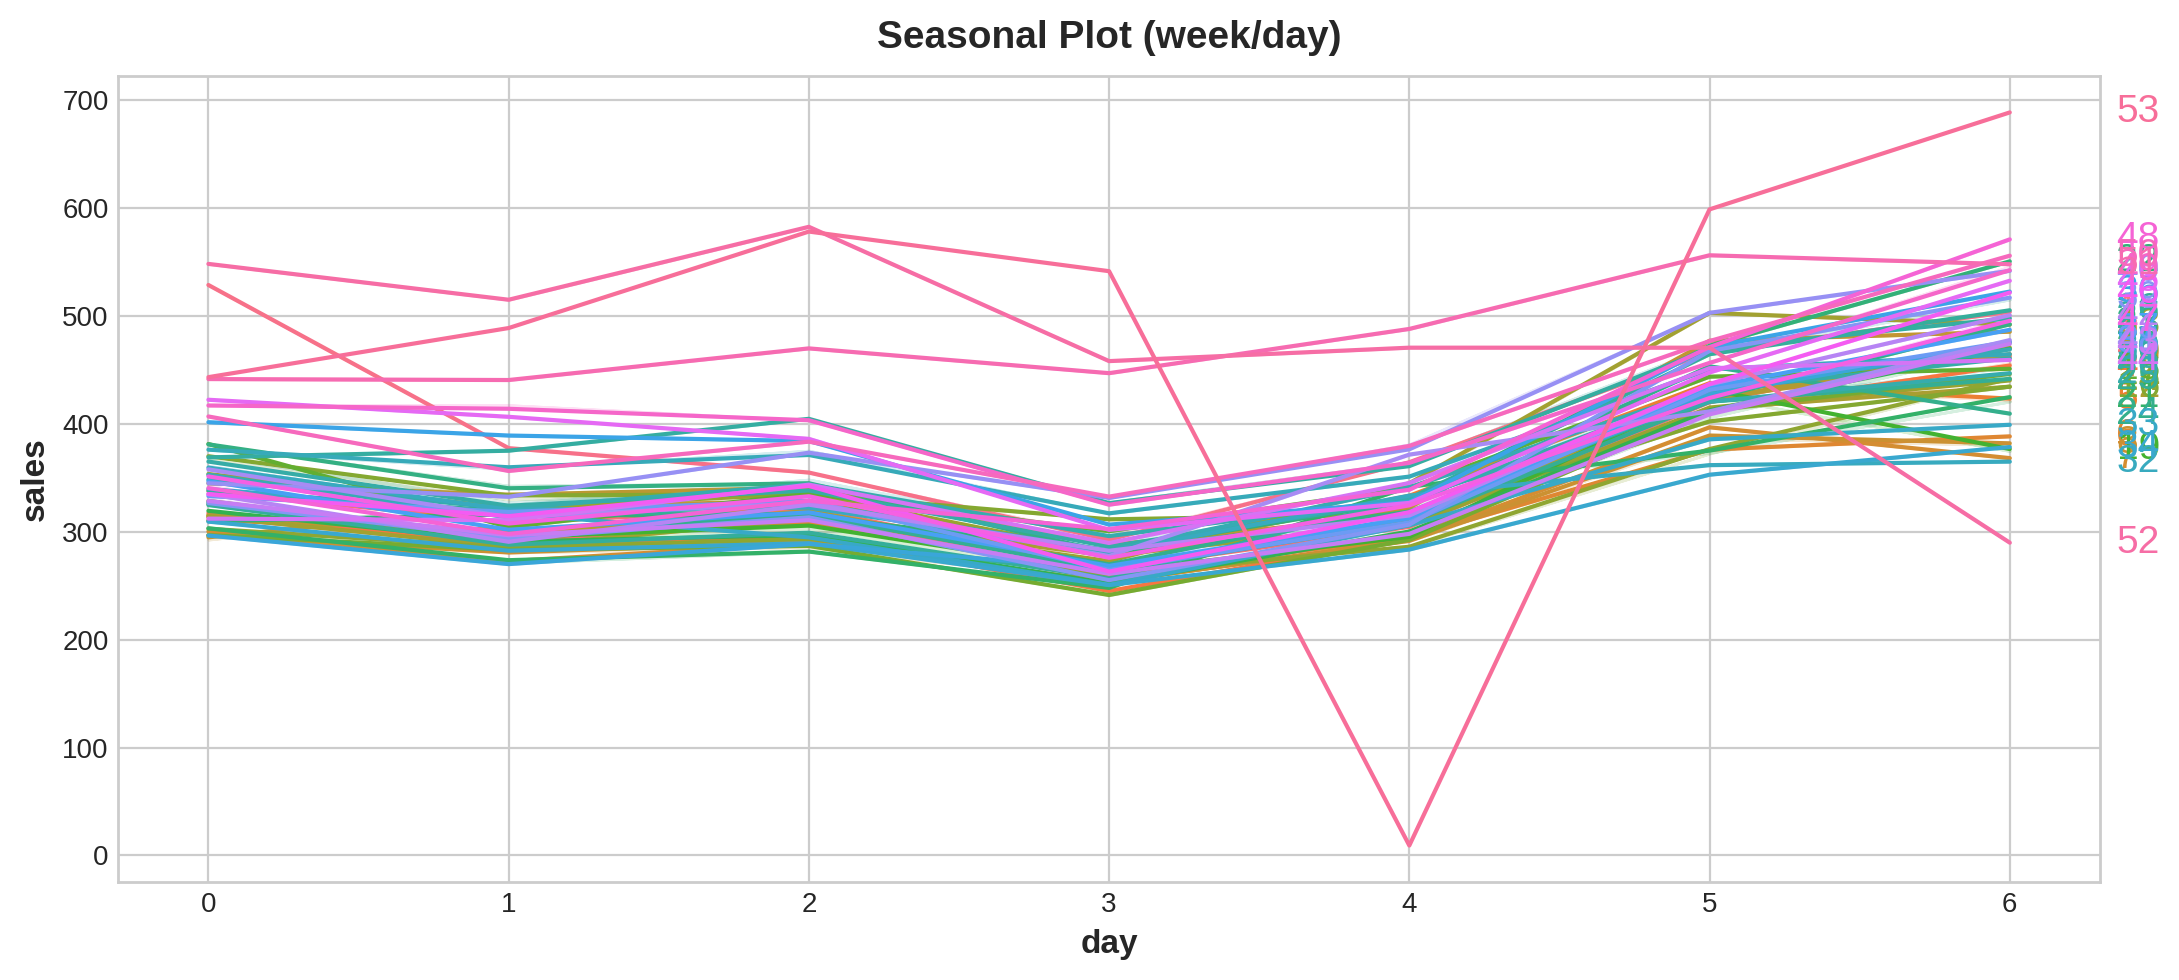

In [ ]:
df1 = df.drop(columns = ['id','onpromotion'])
df1['date'] = df1.date.dt.to_period('D')
store_sales = df1.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
)

X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek

seasonal_plot(X, y='sales', period='week', freq='day');

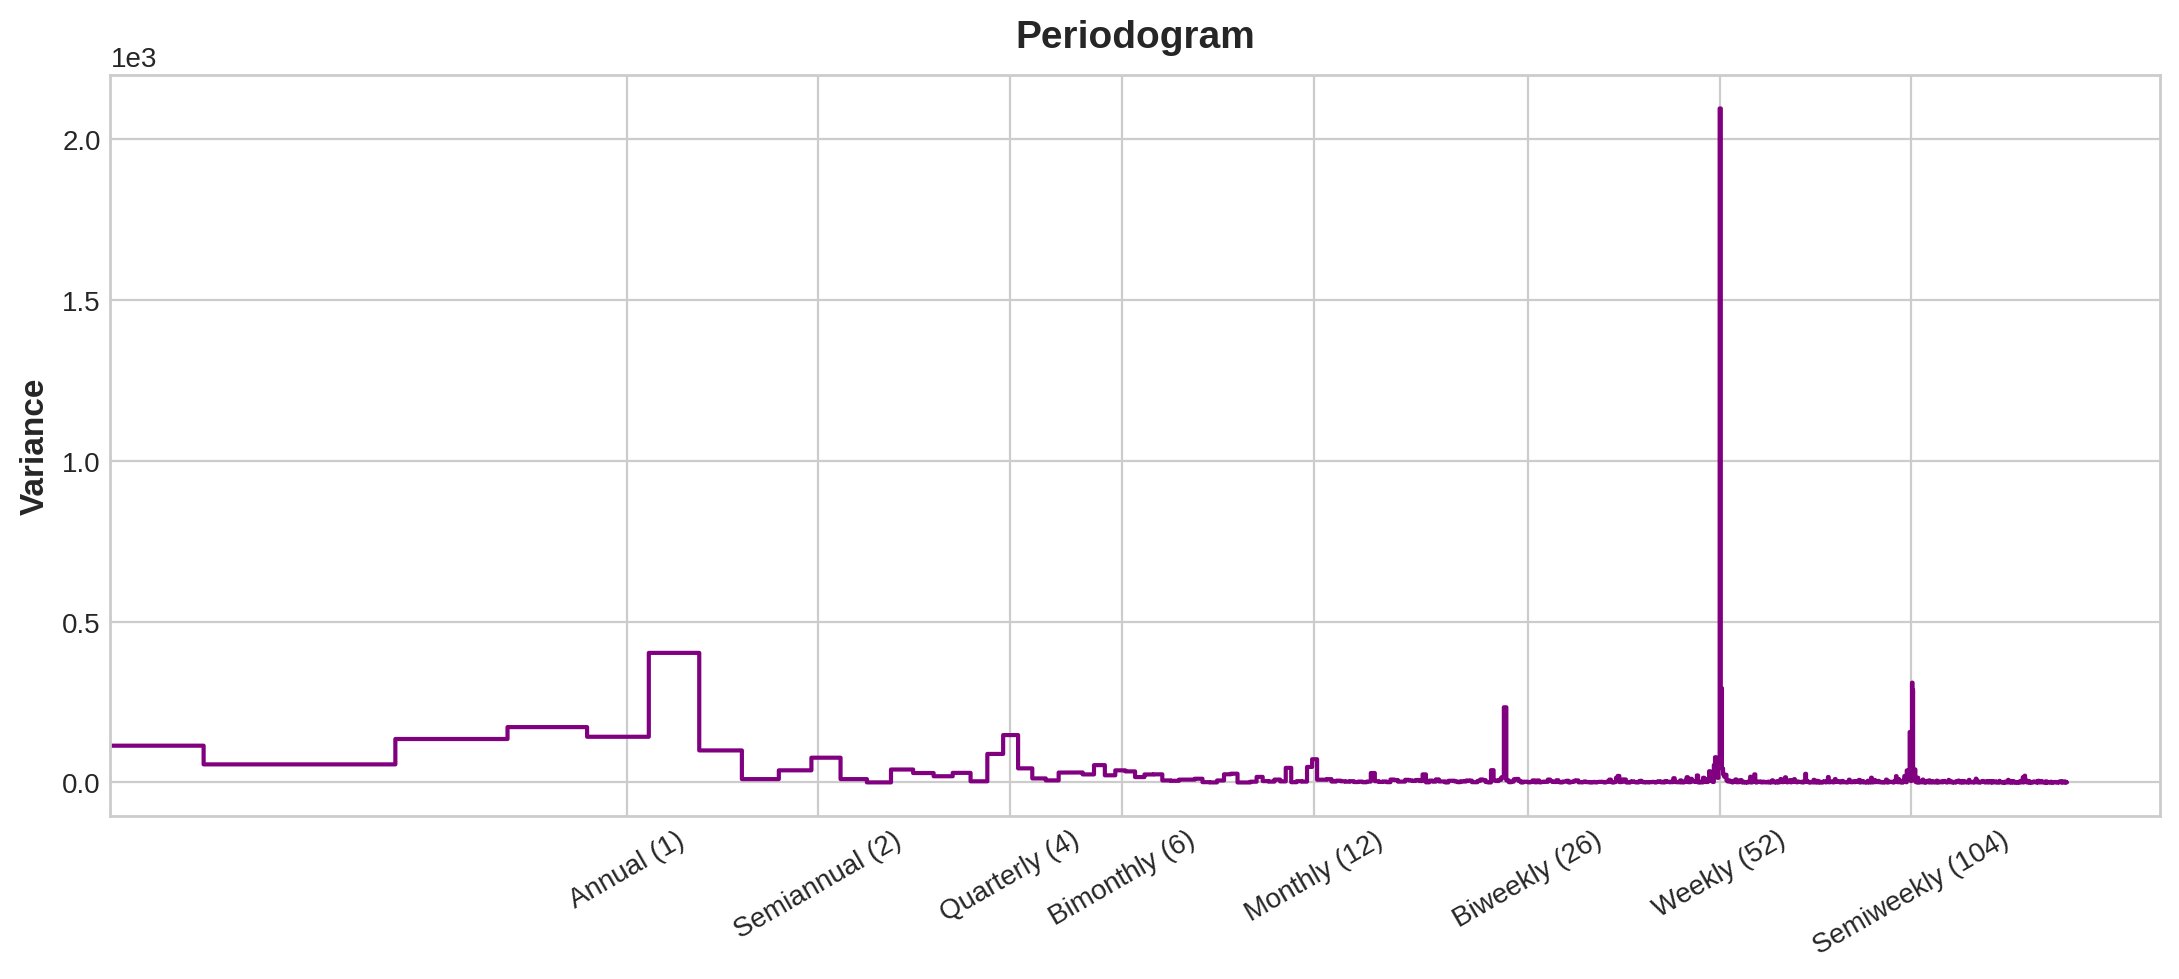

In [ ]:
plot_periodogram(average_sales);

**Observation -** From the periodogram, it is clear that the variance of the data can be better explained weekly and this would come handy when predicting the target for seasonality.

## Predicting the Trend Component

In [ ]:
df_trend_prepared = store_sales.copy()

y = df_trend_prepared.unstack(['store_nbr','family'])  # the target

dp = DeterministicProcess(index = y.index,
                         order=2,
                         drop = True)

X = dp.in_sample()

X_fore = dp.out_of_sample(steps=180)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
y_pred_trend = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
y_pred_trend_fore = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y.columns)

Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object', name='family')

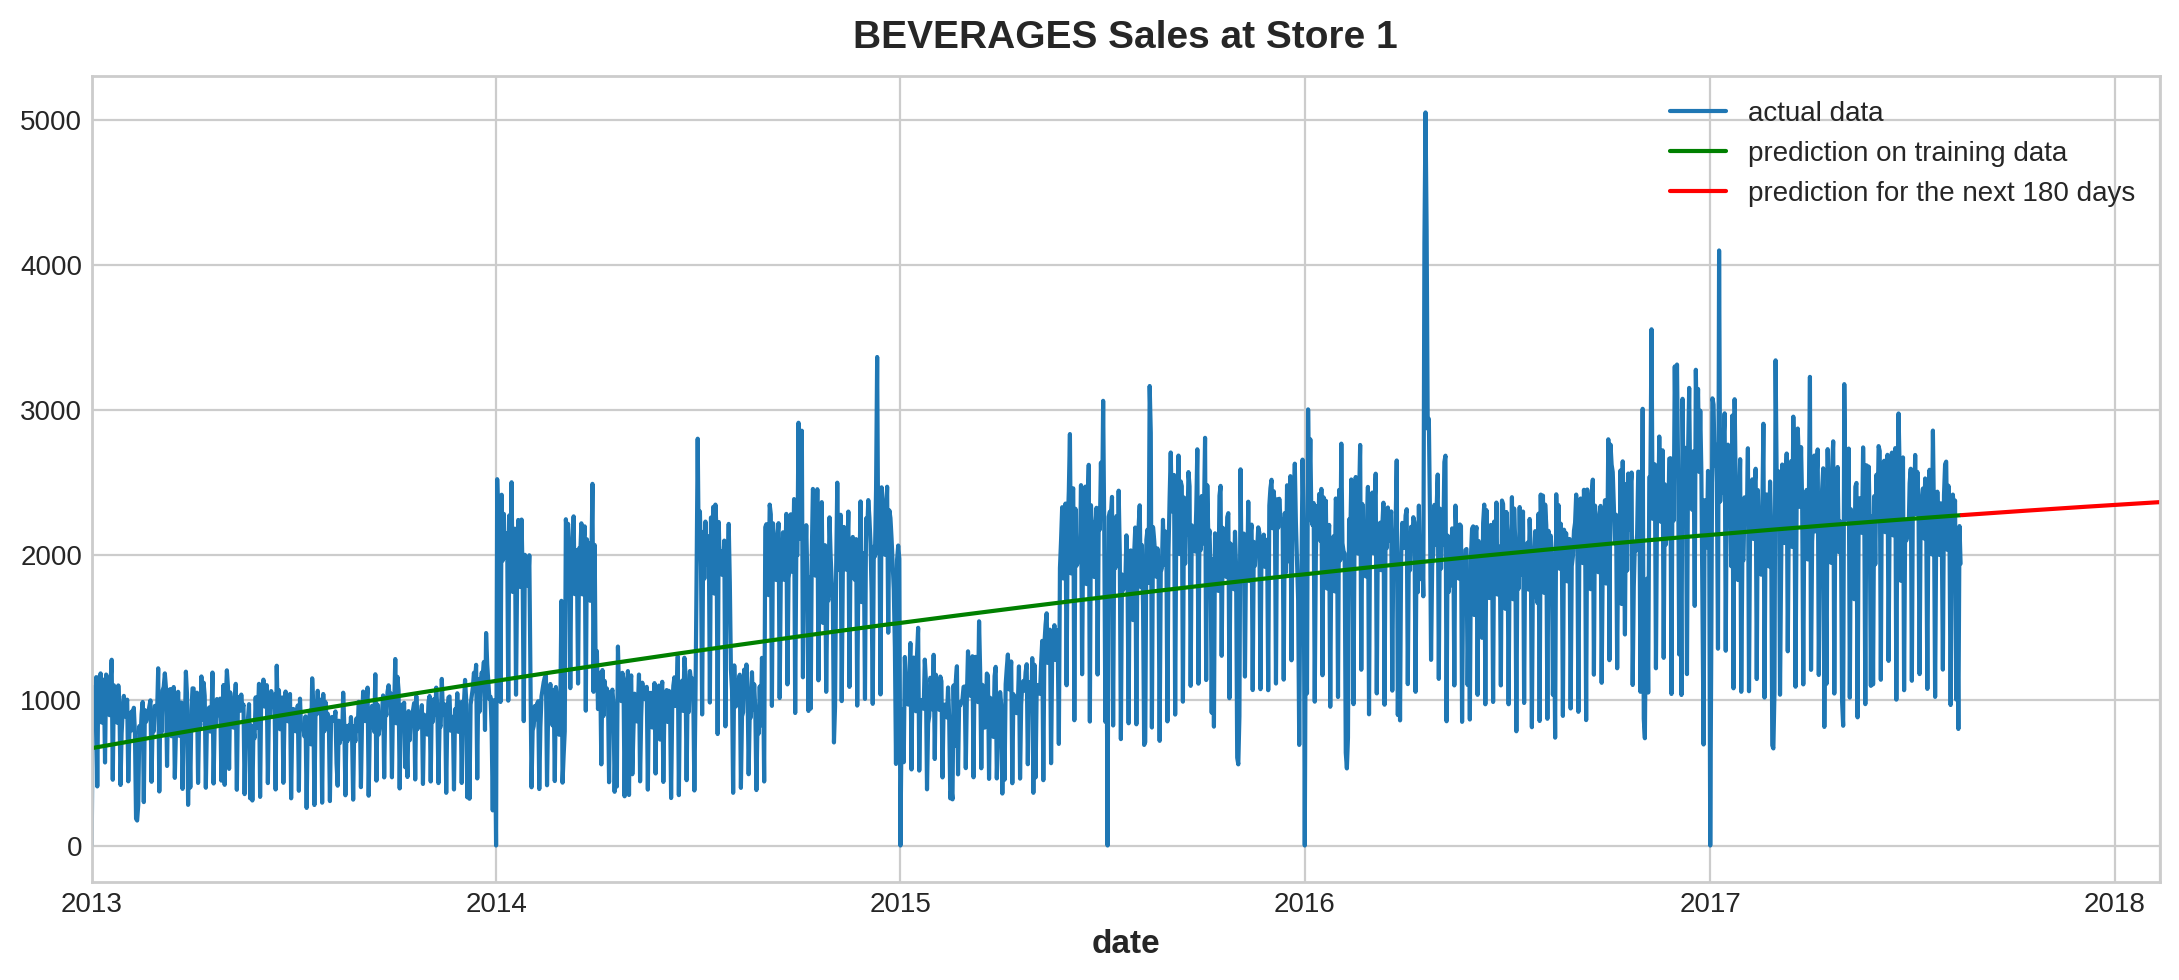

In [ ]:
STORE_NBR = 1  # 1 - 54
FAMILY = 'BEVERAGES'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(label='actual data')
ax = y_pred_trend.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax,label = 'prediction on training data', color = 'g')
ax = y_pred_trend_fore.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax,label = 'prediction for the next 180 days', color = 'r')
ax.legend()
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [ ]:
y_detrended = y - y_pred_trend

## Predicting the Seasonality component

In [ ]:
fourier = CalendarFourier(freq='M', order=4)

dp_season_on_top_of_trend = DeterministicProcess(index=y_detrended.index,
    constant=True,
    order=2,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,)

Xsot = dp_season_on_top_of_trend.in_sample()

X_fore_sot = dp_season_on_top_of_trend.out_of_sample(steps=180)

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
model_st = XGBRegressor()
model_st.fit(Xsot, y_detrended)
y_pred_sot = pd.DataFrame(model_st.predict(Xsot), index=Xsot.index, columns=y_detrended.columns)
y_pred_sot_fore = pd.DataFrame(model_st.predict(X_fore_sot), index=X_fore_sot.index, columns=y_detrended.columns)

Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object', name='family')

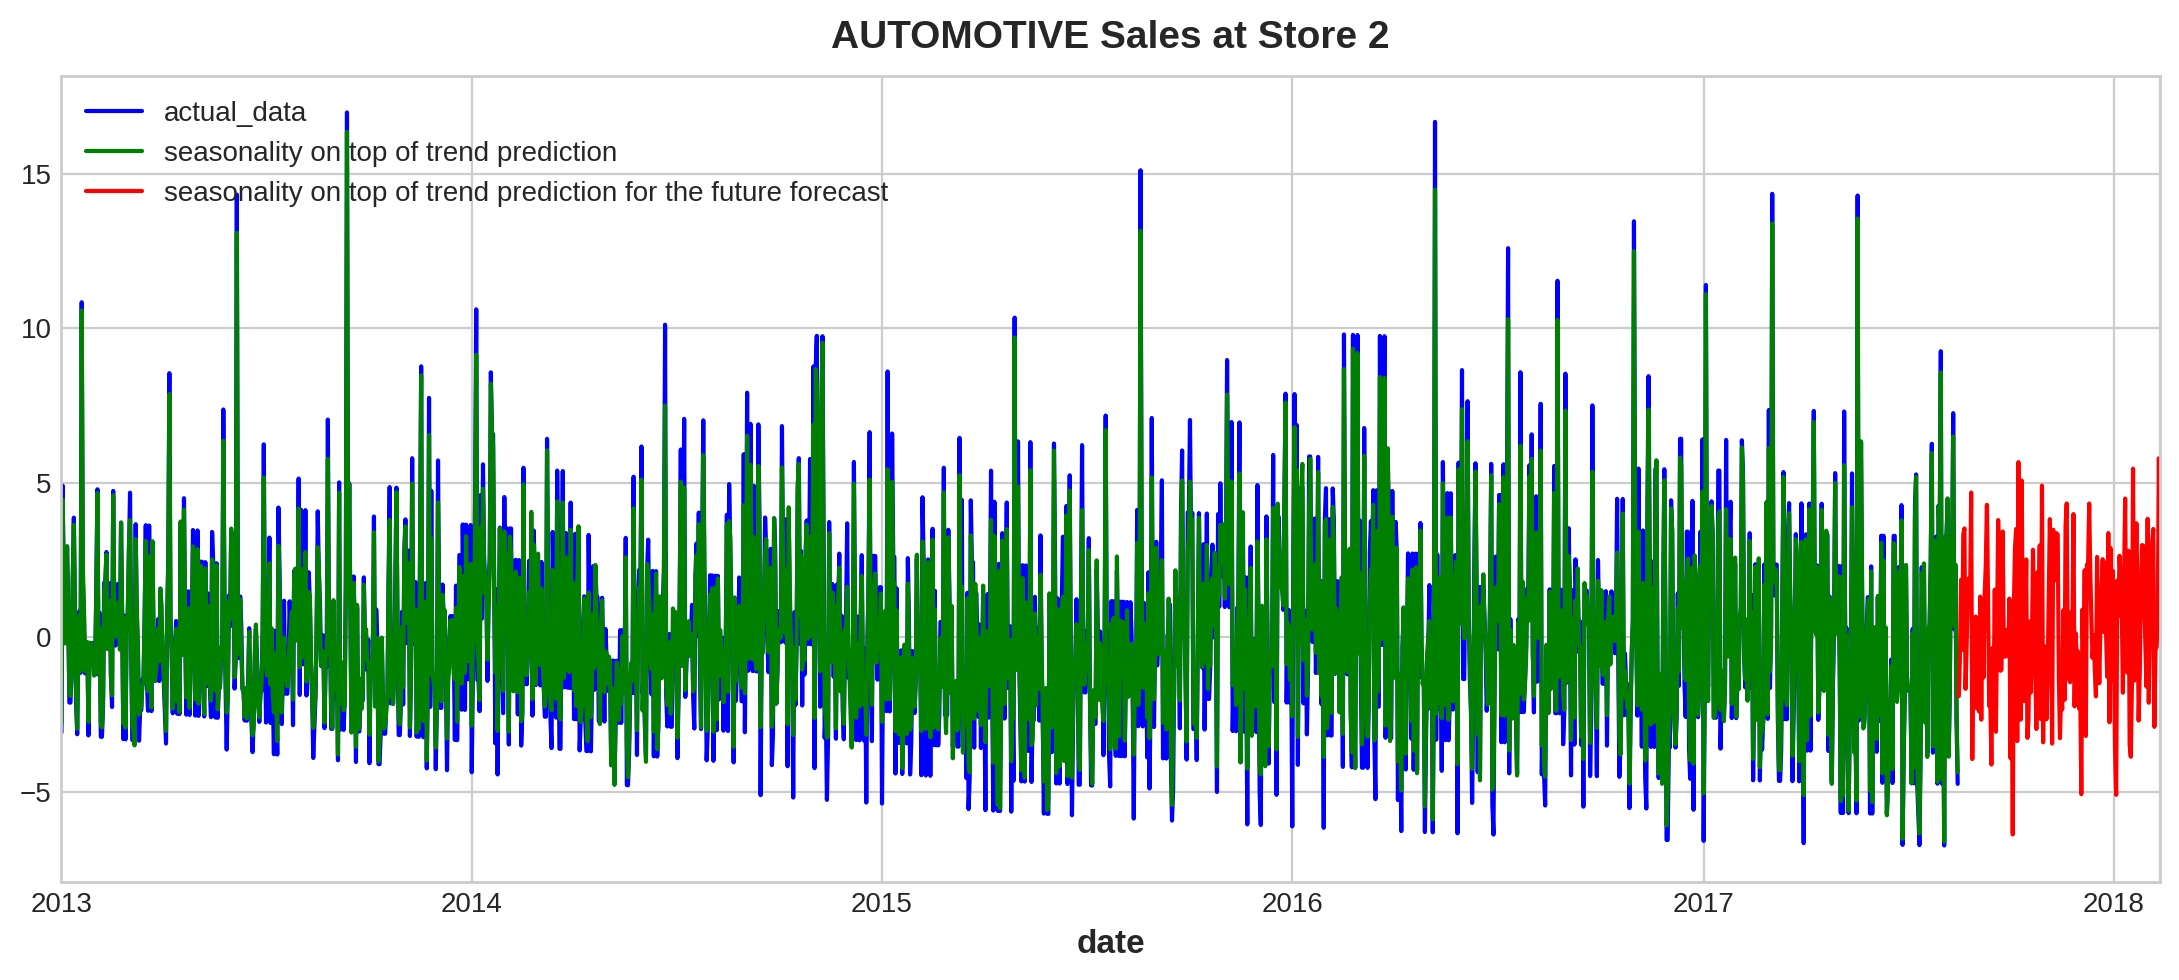

In [ ]:
STORE_NBR = 2  # 1 - 54
FAMILY = 'AUTOMOTIVE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

ax = y_detrended.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(label = 'actual_data', color = 'b')
ax = y_pred_sot.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax,label = 'seasonality on top of trend prediction', color = 'g')
ax = y_pred_sot_fore.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax,label = 'seasonality on top of trend prediction for the future forecast', color = 'r')
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')
ax.legend();

## Combining both the Predictions

In [ ]:
y_pred_final = y_pred_trend + y_pred_sot

from sklearn.metrics import mean_absolute_error
print("The Mean Absolute Error of seasonality on top of trend prediction is", mean_absolute_error(y,y_pred_final))

The Mean Absolute Error of seasonality on top of trend prediction is 9.099409649688184


## Applying the models on the Test Dataset

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Placement projects/store-sales-time-series-forecasting/test.csv',
                 parse_dates = ['date'],
                infer_datetime_format = True,)

X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test_st = dp_season_on_top_of_trend.out_of_sample(steps=16)
X_test_st.index.name = 'date'

df_test_processed = df_test.drop(columns = ['onpromotion'])
df_test_processed['date'] = df_test_processed.date.dt.to_period('D')
df_test_processed = df_test_processed.set_index(['store_nbr','family','date']).sort_index()

## Final Submission

In [ ]:
y_submit_trend = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit_sot = pd.DataFrame(model_st.predict(X_test_st), index=X_test.index, columns=y.columns)
y_submit_final = y_submit_trend + y_submit_sot
y_submit_final = y_submit_final.stack(['store_nbr', 'family'])
y_submit_final = y_submit_final.join(df_test_processed.id).reindex(columns=['id', 'sales'])
y_submit_final.to_csv('submission.csv', index=False)